In [2]:
import sys
import bayesopt
import numpy as np 
from bayesoptmodule import BayesOptContinuous 

ModuleNotFoundError: No module named 'bayesopt'

In [34]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# define the function
def model(t, variables, s, d_m, n_s, n_r, n_t, n_m, n_q, gamma_max, K_gamma, v_t, K_t, v_m, K_m, w_r, w_e, w_t, w_m, w_q, theta_r, theta_nr, K_q, h_q, k_b, k_u, M, k_cm):

    c_r, e_m, c_q, c_t, e_t, c_m, m_t, m_m, q, s_i, m_q, m_r, r, a = variables

    # helper function
    def v_imp(e_t, s):
        return (e_t * v_t * s) / (K_t + s)


    def v_cat(e_m, s_i):
        return (e_m * v_m * s_i) / (K_m + s_i)


    def gamma(a):
        return (gamma_max * a) / (K_gamma + a)


    def v_x(x, c_x, a):
        if x == 'r':
            return (c_x * gamma(a)) / n_r
        elif x == 't':
            return (c_x * gamma(a)) / n_t
        elif x == 'm':
            return (c_x * gamma(a)) / n_m
        else:
            return (c_x * gamma(a)) / n_q

    def omega(x, a):
        if x == 'r':
            return (w_r * a / (theta_r + a))
        elif x == 't':
            return (w_t * a / (theta_nr + a))
        else:
            return (w_m * a / (theta_nr + a))


    def iota(q):
        return 1 / (1 + (q / K_q) ** h_q)


    def omega_q(q, a):
        return w_q * a * iota(q) / (theta_nr + a)

    R_t = (c_r + c_t + c_m + c_q)
    gam = (gamma_max * a) / (K_gamma + a)
    growth_rate = gamma(a) * R_t / M
    
    dcrdt = (k_b * m_r * r) - (k_u * c_r) - v_x('r', c_r, a) - (growth_rate * c_r)
    demdt = v_x('m', c_m, a) - (growth_rate * e_m)
    dcqdt = (k_b * m_q * r) - (k_u * c_q) - v_x('q', c_q, a) - (growth_rate * c_q)
    dctdt = (k_b * m_t * r) - (k_u * c_t) - v_x('t', c_t, a) - (growth_rate * c_t)
    detdt = v_x('t', c_t, a) - (growth_rate * e_t)
    dcmdt = (k_b * m_m * r) - (k_u * c_m) - v_x('m', c_m, a) - (growth_rate * c_m)
    dmtdt = omega('t', a) - (growth_rate + d_m)* m_t - (k_b * r * m_t) + (k_u * c_t) + v_x('t', c_t, a)
    dmmdt = omega('m', a) - (growth_rate + d_m)* m_m - (k_b * r * m_m) + (k_u * c_m) + v_x('m', c_m, a)
    dqdt = v_x('q', c_q, a) - (growth_rate * q)
    dsidt = v_imp(e_t, s) - v_cat(e_m, s_i) - (growth_rate * s_i)
    dmqdt = (w_q*a/(theta_nr+a)/(1+(q/K_q)**h_q)) - (growth_rate + d_m)*m_q - (k_b * r * m_q) + (k_u * c_q) + v_x('q', c_q, a)
    dmrdt = omega('r', a) - (growth_rate + d_m)* m_r - (k_b * r * m_r) + (k_u * c_r) + v_x('r', c_r, a)
    drdt = v_x('r', c_r, a) - (growth_rate * r) + v_x('r', c_r, a) - (k_b * r * m_r) + (k_u * c_r) + v_x('t', c_t, a) - (k_b * r * m_t) + (k_u * c_t) + v_x('m', c_m, a) - (k_b * r * m_m) + (k_u * c_m) + v_x('q', c_q, a) - (k_b * r * m_q) + (k_u * c_q)
    dadt = n_s * v_cat(e_m, s_i) - (R_t*gam) - (growth_rate * a)


    return [dcrdt, demdt, dcqdt, dctdt, detdt, dcmdt, dmtdt, dmmdt, dqdt, dsidt, dmqdt, dmrdt, drdt, dadt]

# params
b= 0
dm= 0.1
kb= 1
ku= 1.0
f= 1
thetar= 426.8693338968694
k_cm= 0.005990373118888
s0= 1e4
gmax= 1260.0
cl= 0
thetax= 4.379733394834643
Kt= 1.0e3
M= 1.0e8
we= 4.139172187824451
Km= 1.0e3
vm= 5800.0
nx= 300.0
Kq= 1.522190403737490e+05
Kp= 180.1378030928276
vt= 726.0
wr= 929.9678874564831
wq= 948.9349882947897
wp= 0.0
hq= 4
nr= 7549.0
ns= 0.5 # chloramphenicol-binding rate

s= [b, dm, kb, ku, f, thetar, k_cm, s0, gmax, cl, thetax, Kt, M, we, Km, vm, nx, Kq, Kp, vt, wr, wq, wp, hq, nr, ns]
y0 = [0 for i in range(14)]
y0[13] = 1000 # initial value of energy
y0[12] = 10 # initial value of ribosomes

t_span = (0, 1e9)
# t = np.arange(0, 900, 0.1)

result_solve_ivp = solve_ivp(model, t_span, y0, method="Radau", args=p)
t = result_solve_ivp.t

s_i = result_solve_ivp.y[9]
a = result_solve_ivp.y[13]
r = result_solve_ivp.y[12]
e_t = result_solve_ivp.y[4]
e_m = result_solve_ivp.y[1]
q = result_solve_ivp.y[8]
m_r = result_solve_ivp.y[11]
m_t = result_solve_ivp.y[6]
m_m = result_solve_ivp.y[7]
m_q = result_solve_ivp.y[10]
c_r = result_solve_ivp.y[0]
c_t = result_solve_ivp.y[3]
c_m = result_solve_ivp.y[5]
c_q = result_solve_ivp.y[2]

print("finish")


fig, ax = plt.subplots(figsize=(15, 15), sharex=True)
ax.plot(t, s_i, 'b-', label='s_i')
ax.plot(t, a, 'g-', label='a')
ax.plot(t, r, 'r-', label='r')
ax.plot(t, e_t, 'c-', label='e_t')
ax.plot(t, e_m, 'm-', label='e_m')
ax.plot(t, q, 'y-', label='q')
ax.plot(t, m_r, 'peachpuff', label='m_r')
ax.plot(t, m_t, 'darkorange', label='m_t')
ax.plot(t, m_m, 'limegreen', label='m_m')
ax.plot(t, m_q, 'royalblue', label='m_q')
ax.plot(t, c_r, 'navy', label='c_r')
ax.plot(t, c_t, 'wheat', label='c_t')
ax.plot(t, c_m, 'lightcoral', label='c_m')
ax.plot(t, c_q, 'dodgerblue', label='c_q')
ax.set_ylabel('growth_rate')
ax.set_xlabel('time(s)')

ax.legend()
# plt.savefig('model_4500.png')
plt.show()


TypeError: model() missing 1 required positional argument: 'k_cm'

In [30]:
print(np.shape(y0))

(14,)


In [72]:
# define the function
def model(t, variables, s, d_m, n_s, n_r, n_t, n_m, n_q, gamma_max, v_t, K_t, v_m, K_m, w_r, w_t, w_m, \
    w_q, theta_r, theta_nr, K_q, h_q, k_b, k_u, M):

    s_i, a, r, e_t, e_m, q, m_r, m_t, m_m, m_q, c_r, c_t, c_m, c_q, c_p, p, m_p = variables
    K_gamma=gamma_max/K_p

    # helper function
    def v_imp(e_t, s):
        return e_t * v_t * s / (K_t + s)


    def v_cat(e_m, s_i):
        return e_m * v_m * s_i / (K_m + s_i)


    def gamma(a):
        return gamma_max * a / (K_gamma + a)


    def v_x(x, c_x, a):
        if x == 'r':
            return c_x * gamma(a) / n_r
        elif x == 't':
            return c_x * gamma(a) / n_t
        elif x == 'm':
            return c_x * gamma(a) / n_m
        else:
            return c_x * gamma(a) / n_q

    def omega(x, a):
        if x == 'r':
            return w_r * a / (theta_r + a)
        elif x == 't':
            return w_t * a / (theta_nr + a)
        else:
            return w_m * a / (theta_nr + a)


    def iota(q):
        return 1 / (1 + (q / K_q) ** h_q)


    def omega_q(q, a):
        return w_q * a * iota(q) / (theta_nr + a)

    R_t = c_r + c_t + c_m + c_q+c_p
    growth_rate = gamma(a) * R_t / M

    dsidt = v_imp(e_t, s) - v_cat(e_m, s_i) - growth_rate * s_i
    dadt = n_s * v_cat(e_m, s_i) - gamma(a)*R_t - growth_rate * a
    drdt = v_x('r', c_r, a) - growth_rate * r + v_x('r', c_r, a) - k_b * r * m_r + k_u * c_r + v_x('t', c_t, a) - k_b * r * m_t + k_u * c_t \
            + v_x('m', c_m, a) - k_b * r * m_m + k_u * c_m + v_x('q', c_q, a) - k_b * r * m_q + k_u * c_q -(r*m_p*k_b) +(c_p*k_u) +(c_p*gamma(a))/nx
    detdt = v_x('t', c_t, a) - growth_rate * e_t
    demdt = v_x('m', c_m, a) - growth_rate * e_m
    dqdt = v_x('q', c_q, a) - growth_rate * q
    dmrdt = omega('r', a) - (growth_rate + d_m) * m_r - k_b * r * m_r + k_u * c_r + v_x('r', c_r, a)
    dmtdt = omega('t', a) - (growth_rate + d_m) * m_t - k_b * r * m_t + k_u * c_t + v_x('t', c_t, a)
    dmmdt = omega('m', a) - (growth_rate + d_m) * m_m - k_b * r * m_m + k_u * c_m + v_x('m', c_m, a)
    dmqdt = omega_q(q, a) - (growth_rate + d_m) * m_q - k_b * r * m_q + k_u * c_q + v_x('q', c_q, a)
    dcrdt = k_b * m_r * r - k_u * c_r - v_x('r', c_r, a) - growth_rate * c_r
    dctdt = k_b * m_t * r - k_u * c_t - v_x('t', c_t, a) - growth_rate * c_t
    dcmdt = k_b * m_m * r - k_u * c_m - v_x('m', c_m, a) - growth_rate * c_m
    dcqdt = k_b * m_q * r - k_u * c_q - v_x('q', c_q, a) - growth_rate * c_q
    dcpdt = + (r*m_p*kb) - (c_p*ku) - (c_p*growth_rate) - (c_p*gamma(a))/nx - (f*c_p)
    dpdt = - (growth_rate*p) + (c_p*gamma(a))/nx
    dmpdt = + (wp*a/(thetax+a)) - m_p*(growth_rate+dm) - (r*m_p*kb) + (c_p*ku) + (c_p*gamma(a))/nx


    return [dsidt, dadt, drdt, detdt, demdt, dqdt, dmrdt, dmtdt, dmmdt, dmqdt, dcrdt, dctdt, dcmdt, dcqdt, dcpdt, dpdt, dmpdt]



In [73]:
# params
b= 0
d_m= 0.1
k_b= 1
k_u= 1.0
f= 1
theta_r= 426.8693338968694
k_cm= 0.005990373118888
s= 1e4
gamma_max= 1260.0
cl= 0
theta_nr= 4.379733394834643
K_t= 1.0e3
M= 1.0e8
w_e,w_t,w_m= 4.139172187824451,4.139172187824451,4.139172187824451
K_m= 1.0e3
v_m= 5800.0
n_t,n_m,n_q= 300.0,300.0,300.0
K_q= 1.522190403737490e+05
K_p= 180.1378030928276
v_t= 726.0
w_r= 929.9678874564831
w_q= 948.9349882947897
w_p= 0.0
h_q= 4
n_r= 7549.0
n_s= 0.5

p = (s, d_m, n_s, n_r, n_t, n_m, n_q, gamma_max, v_t, K_t, v_m, K_m, w_r, w_t, w_m, \
    w_q, theta_r, theta_nr, K_q, h_q, k_b, k_u, M)

y0 = [0 for i in range(17)]
y0[1] = 1000 # initial value of energy
y0[2] = 10 # initial value of ribosomes

t_span = (0, 1e9)



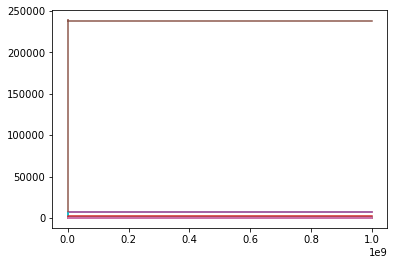

In [74]:

sol = solve_ivp(model, t_span, y0, args=p, method="Radau")
# t = result_solve_ivp.t

for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=f'$X_{i}(t)$')
plt.show()

# s_i = result_solve_ivp.y[0]
# a = result_solve_ivp.y[1]
# r = result_solve_ivp.y[2]
# e_t = result_solve_ivp.y[3]
# e_m = result_solve_ivp.y[4]
# q = result_solve_ivp.y[5]
# m_r = result_solve_ivp.y[6]
# m_t = result_solve_ivp.y[7]
# m_m = result_solve_ivp.y[8]
# m_q = result_solve_ivp.y[9]
# c_r = result_solve_ivp.y[10]
# c_t = result_solve_ivp.y[11]
# c_m = result_solve_ivp.y[12]
# c_q = result_solve_ivp.y[13]


In [75]:
print(gamma_max/K_p)

6.994645090407281


finish


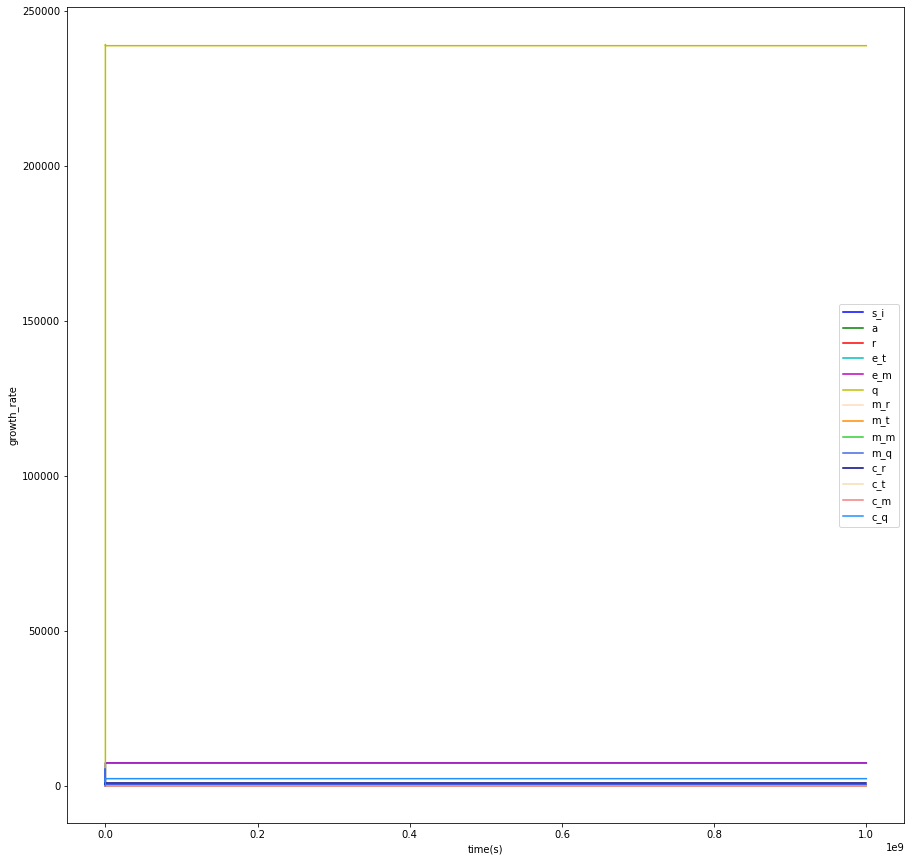

In [79]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# define the function
def model(t, variables, s, d_m, n_s, n_r, n_t, n_m, n_q, gamma_max, K_gamma, v_t, K_t, v_m, K_m, w_r, w_e, w_t, w_m, \
    w_q, theta_r, theta_nr, K_q, h_q, k_b, k_u, M, k_cm):

    s_i, a, r, e_t, e_m, q, m_r, m_t, m_m, m_q, c_r, c_t, c_m, c_q = variables

    # helper function
    def v_imp(e_t, s):
        return e_t * v_t * s / (K_t + s)


    def v_cat(e_m, s_i):
        return e_m * v_m * s_i / (K_m + s_i)


    def gamma(a):
        return gamma_max * a / (K_gamma + a)


    def v_x(x, c_x, a):
        if x == 'r':
            return c_x * gamma(a) / n_r
        elif x == 't':
            return c_x * gamma(a) / n_t
        elif x == 'm':
            return c_x * gamma(a) / n_m
        else:
            return c_x * gamma(a) / n_q

    def omega(x, a):
        if x == 'r':
            return w_r * a / (theta_r + a)
        elif x == 't':
            return w_t * a / (theta_nr + a)
        else:
            return w_m * a / (theta_nr + a)


    def iota(q):
        return 1 / (1 + (q / K_q) ** h_q)


    def omega_q(q, a):
        return w_q * a * iota(q) / (theta_nr + a)

    R_t = c_r + c_t + c_m + c_q
    growth_rate = gamma(a) * R_t / M

    dsidt = v_imp(e_t, s) - v_cat(e_m, s_i) - growth_rate * s_i
    dadt = n_s * v_cat(e_m, s_i) -gamma(a)*R_t  - growth_rate * a
    drdt = v_x('r', c_r, a) - growth_rate * r + v_x('r', c_r, a) - k_b * r * m_r + k_u * c_r + v_x('t', c_t, a) - k_b * r * m_t + k_u * c_t \
            + v_x('m', c_m, a) - k_b * r * m_m + k_u * c_m + v_x('q', c_q, a) - k_b * r * m_q + k_u * c_q
    detdt = v_x('t', c_t, a) - growth_rate * e_t
    demdt = v_x('m', c_m, a) - growth_rate * e_m
    dqdt = v_x('q', c_q, a) - growth_rate * q
    dmrdt = omega('r', a) - (growth_rate + d_m) * m_r - k_b * r * m_r + k_u * c_r + v_x('r', c_r, a)
    dmtdt = omega('t', a) - (growth_rate + d_m) * m_t - k_b * r * m_t + k_u * c_t + v_x('t', c_t, a)
    dmmdt = omega('m', a) - (growth_rate + d_m) * m_m - k_b * r * m_m + k_u * c_m + v_x('m', c_m, a)
    dmqdt = omega_q(q, a) - (growth_rate + d_m) * m_q - k_b * r * m_q + k_u * c_q + v_x('q', c_q, a)
    dcrdt = k_b * m_r * r - k_u * c_r - v_x('r', c_r, a) - growth_rate * c_r 
    dctdt = k_b * m_t * r - k_u * c_t - v_x('t', c_t, a) - growth_rate * c_t 
    dcmdt = k_b * m_m * r - k_u * c_m - v_x('m', c_m, a) - growth_rate * c_m 
    dcqdt = k_b * m_q * r - k_u * c_q - v_x('q', c_q, a) - growth_rate * c_q 

    return [dsidt, dadt, drdt, detdt, demdt, dqdt, dmrdt, dmtdt, dmmdt, dmqdt, dcrdt, dctdt, dcmdt, dcqdt]

# params
s = 10 ** 4  # external nutrient
d_m = 0.1  # mRNA-degradation rate
n_s = 0.5  # nutrient efficiency
n_r = 7459  # ribosome length
n_t, n_m, n_q = 300, 300, 300  # length of non-ribosomal proteins
gamma_max = 1260  # max. transl. elongation rate
K_gamma = 7  # transl. elongation threshold
v_t = 726  # max. nutrient import rate
K_t = 1000  # nutrient import threshold
v_m = 5800  # max. enzymatic rate
K_m = 1000  # enzymatic threshold
w_r = 930  # max. ribosome transcription rate
w_e, w_t, w_m = 4.14, 4.14, 4.14  # max. enzyme transcription rate
w_q = 948.93  # max. q-transcription rate
theta_r = 426.87  # ribosome transcription threshold
theta_nr = 4.38  # non-ribosomal transcription threshold
K_q = 152219  # q-autoinhibition threshold
h_q = 4  # q-autoinhibition Hill coeff.
k_b = 1  # mRNA-ribosome binding rate
k_u = 1  # mRNA-ribosome unbinding rate
M = 10 ** 8  # total cell mass
k_cm = 0.00599  # chloramphenicol-binding rate

p = (s, d_m, n_s, n_r, n_t, n_m, n_q, gamma_max, K_gamma, v_t, K_t, v_m, K_m, w_r, w_e, w_t, w_m, \
    w_q, theta_r, theta_nr, K_q, h_q, k_b, k_u, M, k_cm)

y0 = [0 for i in range(14)]
y0[1] = 1000 # initial value of energy
y0[2] = 10 # initial value of ribosomes

t_span = (0, 1e9)
t = np.arange(0, 900, 0.1)

result_solve_ivp = solve_ivp(model, t_span, y0, method="BDF", args=p)
t = result_solve_ivp.t

s_i = result_solve_ivp.y[0]
a = result_solve_ivp.y[1]
r = result_solve_ivp.y[2]
e_t = result_solve_ivp.y[3]
e_m = result_solve_ivp.y[4]
q = result_solve_ivp.y[5]
m_r = result_solve_ivp.y[6]
m_t = result_solve_ivp.y[7]
m_m = result_solve_ivp.y[8]
m_q = result_solve_ivp.y[9]
c_r = result_solve_ivp.y[10]
c_t = result_solve_ivp.y[11]
c_m = result_solve_ivp.y[12]
c_q = result_solve_ivp.y[13]

print("finish")


fig, ax = plt.subplots(figsize=(15, 15), sharex=True)
ax.plot(t, s_i, 'b-', label='s_i')
ax.plot(t, a, 'g-', label='a')
ax.plot(t, r, 'r-', label='r')
ax.plot(t, e_t, 'c-', label='e_t')
ax.plot(t, e_m, 'm-', label='e_m')
ax.plot(t, q, 'y-', label='q')
ax.plot(t, m_r, 'peachpuff', label='m_r')
ax.plot(t, m_t, 'darkorange', label='m_t')
ax.plot(t, m_m, 'limegreen', label='m_m')
ax.plot(t, m_q, 'royalblue', label='m_q')
ax.plot(t, c_r, 'navy', label='c_r')
ax.plot(t, c_t, 'wheat', label='c_t')
ax.plot(t, c_m, 'lightcoral', label='c_m')
ax.plot(t, c_q, 'dodgerblue', label='c_q')
ax.set_ylabel('growth_rate')
ax.set_xlabel('time(s)')

ax.legend()
plt.savefig('model_4500.png')
plt.show()
